In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import torch
from torch import nn

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/fs01/home/tinbeh/mimic/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from networks import IMVTensorLSTM

In [5]:
data = pd.read_csv("NASDAQ/nasdaq100_padding.csv")

In [6]:
batch_size = 128
timesteps = 20
n_timeseries = data.shape[1]
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [7]:
X = np.zeros((len(data), timesteps, data.shape[1]))

In [8]:
for i, name in enumerate(list(data.columns)):
    print(name)
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

AAL
AAPL
ADBE
ADI
ADP
ADSK
AKAM
ALXN
AMAT
AMGN
AMZN
ATVI
AVGO
BBBY
BIDU
BIIB
CA
CELG
CERN
CMCSA
COST
CSCO
CSX
CTRP
CTSH
DISCA
DISH
DLTR
EA
EBAY
ESRX
EXPE
FAST
FB
FOX
FOXA
GILD
GOOGL
INTC
JD
KHC
LBTYA
LBTYK
LRCX
MAR
MAT
MCHP
MDLZ
MSFT
MU
MXIM
MYL
NCLH
NFLX
NTAP
NVDA
NXPI
PAYX
PCAR
PYPL
QCOM
QVCA
ROST
SBUX
SIRI
STX
SWKS
SYMC
TMUS
TRIP
TSCO
TSLA
TXN
VIAB
VOD
VRTX
WBA
WDC
WFM
XLNX
YHOO
NDX


In [9]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [10]:
X = X[timesteps:]
target = target[timesteps:]

In [11]:
X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [12]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [13]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [14]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [15]:
To_cuda = False
if torch.cuda.is_available():
    print('cuda is available')
    To_cuda = True
model = IMVTensorLSTM(X_train_t.shape[2], 1, 128, To_cuda=To_cuda)
if To_cuda:
    model = model.cuda()

In [16]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [18]:
from torch.utils.data import TensorDataset, DataLoader
data_train_loader = DataLoader(TensorDataset(X_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, target_test_t), shuffle=False, batch_size=128)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from tqdm import tqdm

In [20]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in tqdm(range(epochs)):
    mse_train = 0
    for batch_x, batch_y in data_train_loader:
        if(To_cuda):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in data_val_loader:
            if(To_cuda):
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_tensor_lstm_nasdaq.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("lr: ", opt.param_groups[0]["lr"])
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [29]:
model.load_state_dict(torch.load("imv_tensor_lstm_nasdaq.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [32]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [33]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [34]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [35]:
mse, mae

(2.1215408, 0.9473822)

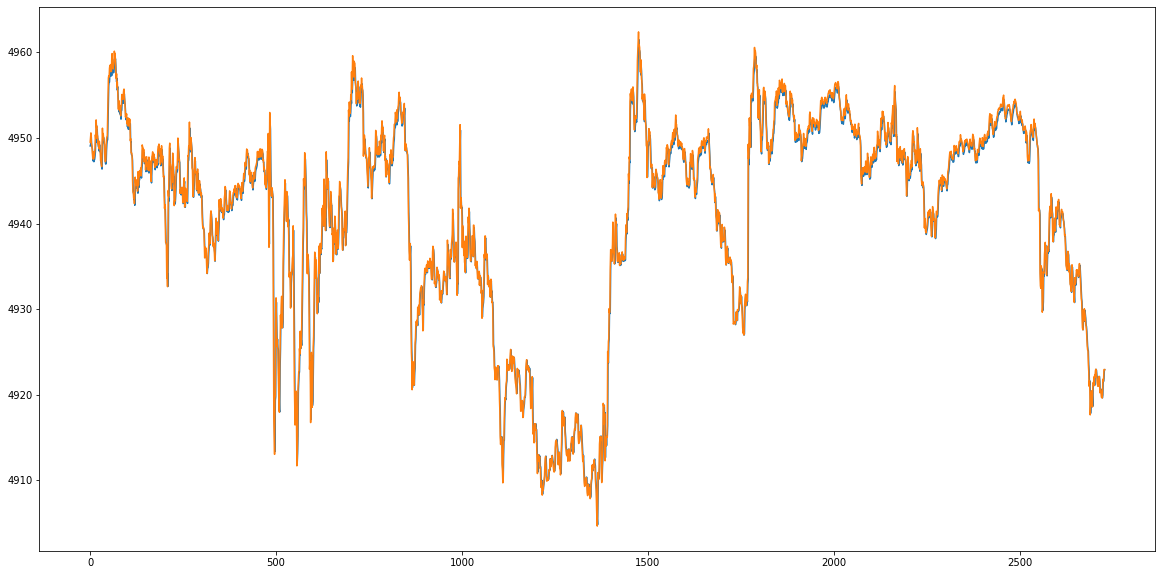

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [38]:
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [39]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [40]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [42]:
alphas = alphas.transpose(1, 0)

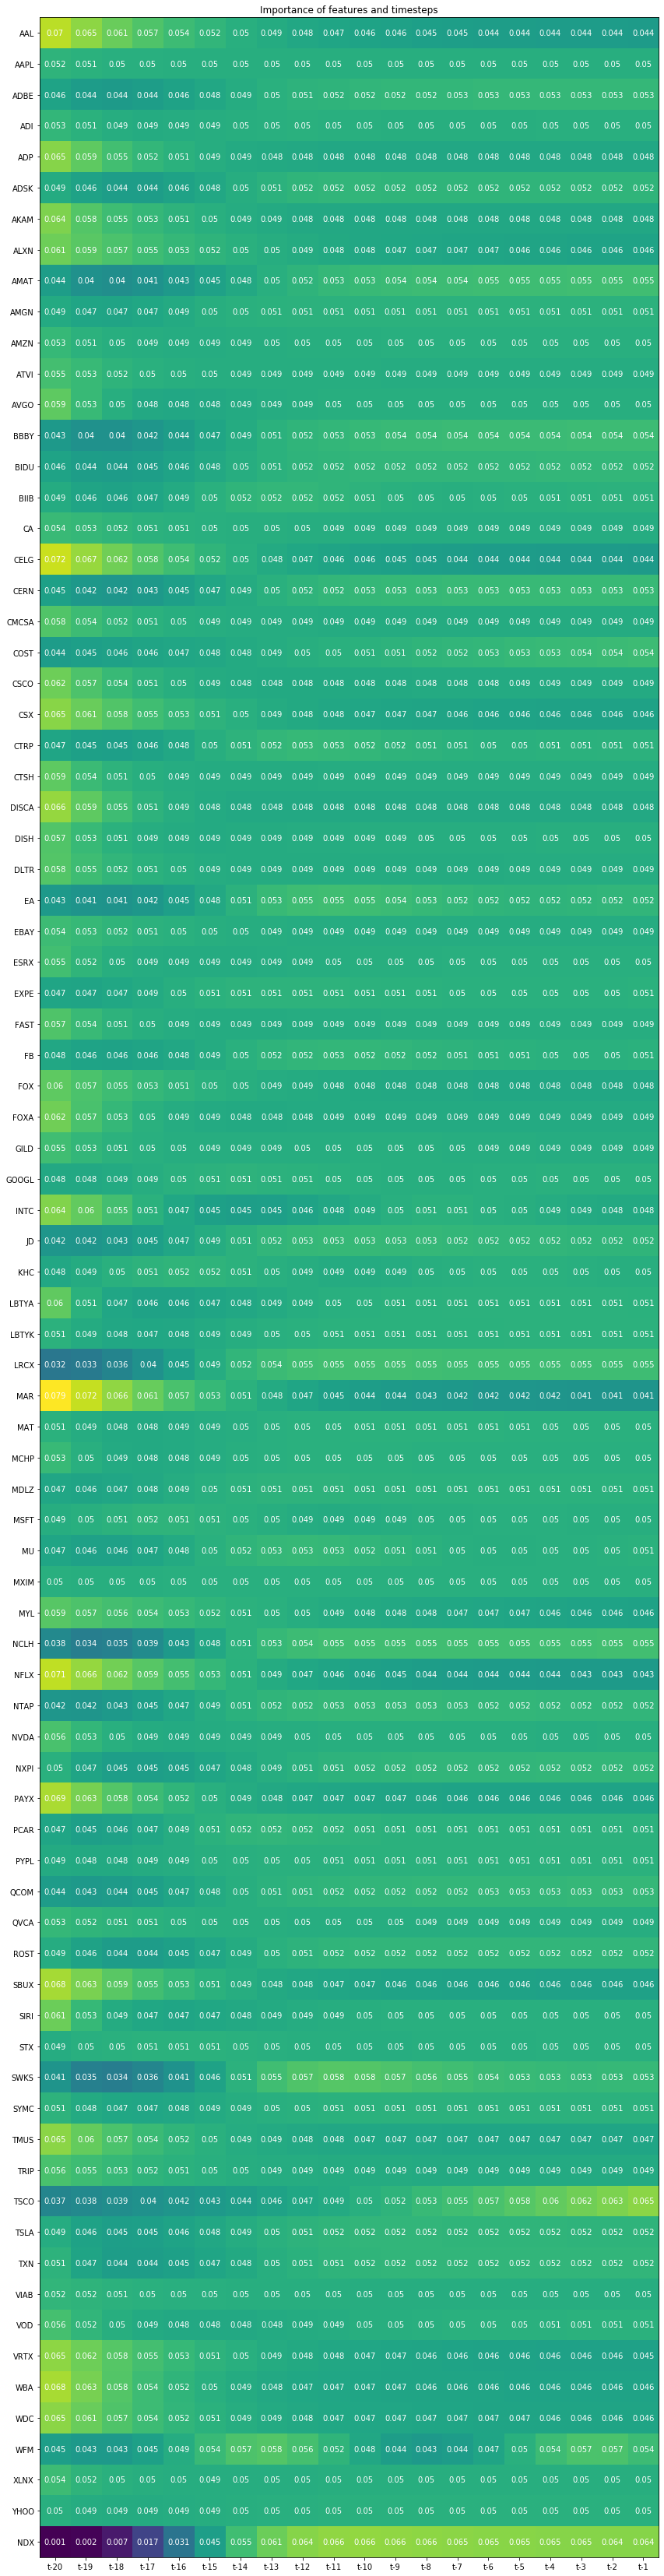

In [53]:
fig, ax = plt.subplots(figsize=(60, 60))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(data.columns)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(list(data.columns))
for i in range(len(data.columns)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f8a22c06160>,
 <a list of 82 Text xticklabel objects>)

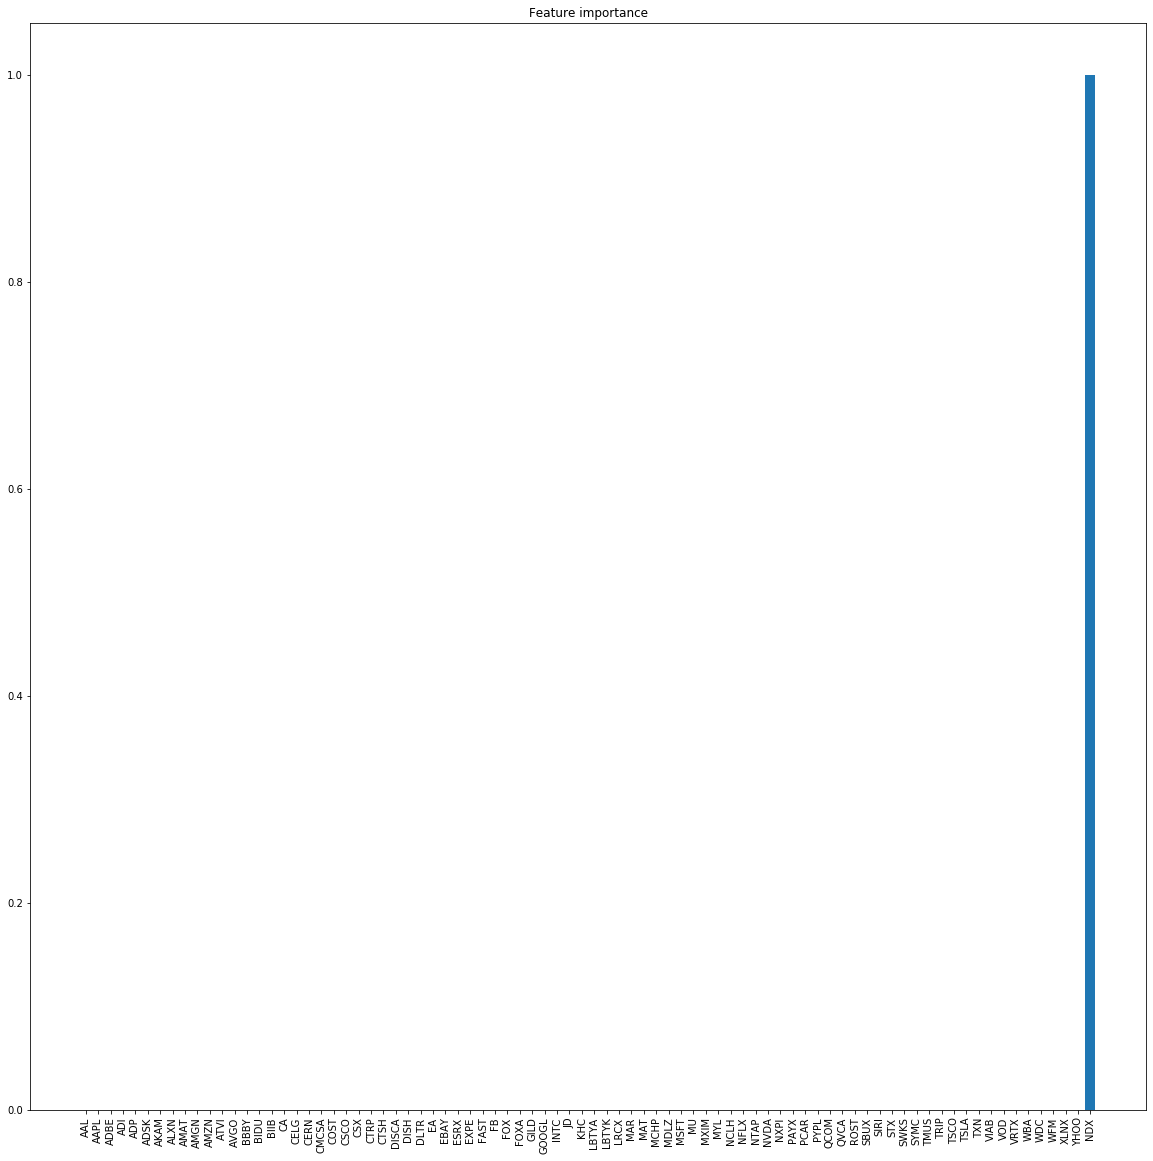

In [50]:
plt.figure(figsize=(20, 20))
plt.title("Feature importance")
plt.bar(range(len(data.columns)), betas)
plt.xticks(ticks=range(len(data.columns)), labels=list(data.columns), rotation=90)